In [99]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy as sc

In [100]:
#Jacobian, inverse_jacobian , shape_function and B functions for elements



@njit
def N(xi,n):
    return (1/4 * np.array([   1 - n - xi + n*xi, 
                                        1 - n + xi - n*xi, 
                                        1 + n + xi + n*xi,
                                        1 + n - xi - n*xi])
            )
@njit
def J(x_vector, y_vector,xi,n):
    return 0.25 * np.array([
    [np.dot(np.array([-1 + n , 1 - n , 1 + n , -1 -n ]),x_vector)      ,   np.dot(np.array([-1 + n , 1 - n , 1 + n , -1 -n ]),y_vector)],
    
    [np.dot(np.array([-1 + xi, -1 -xi, 1 + xi, 1 - xi]),x_vector)      ,   np.dot(np.array([-1 + xi, -1 -xi, 1 + xi, 1 - xi]),y_vector)]
])
@njit
def J_inv(x_vector, y_vector, xi, n):
    return np.linalg.inv(J(x_vector,y_vector, xi, n))
@njit
def B(xi,n,J_inv):
    return 0.25 * J_inv @ np.array([
    [-1 + n , 1 - n , 1 + n , -1 -n ],
    [-1 + xi, -1 -xi, 1 + xi, 1 - xi]
    ])





    
"""
J_inv = lambda x_vector, y_vector: 0.25 * (
    1/((-1*x_vector[0] + x_vector[1] + x_vector[2] - x_vector[3])*(-y_vector[0] - y_vector[1] + y_vector[2] + y_vector[3]) 
    - 
    (-y_vector[0] + y_vector[1] + y_vector[2] -y_vector[3])*(-x_vector[0] - x_vector[1] + x_vector[2] + x_vector[3]))
    
    *
    
    [
    [-y_vector[0] - y_vector[1] + y_vector[2] + y_vector[3],
     -(-y_vector[0] + y_vector[1] + y_vector[2] -y_vector[3])],
    
    [-(-x_vector[0] - x_vector[1] + x_vector[2] + x_vector[3]),
     -1*x_vector[0] + x_vector[1] + x_vector[2] - x_vector[3]]
])
"""


'\nJ_inv = lambda x_vector, y_vector: 0.25 * (\n    1/((-1*x_vector[0] + x_vector[1] + x_vector[2] - x_vector[3])*(-y_vector[0] - y_vector[1] + y_vector[2] + y_vector[3]) \n    - \n    (-y_vector[0] + y_vector[1] + y_vector[2] -y_vector[3])*(-x_vector[0] - x_vector[1] + x_vector[2] + x_vector[3]))\n\n    *\n\n    [\n    [-y_vector[0] - y_vector[1] + y_vector[2] + y_vector[3],\n     -(-y_vector[0] + y_vector[1] + y_vector[2] -y_vector[3])],\n\n    [-(-x_vector[0] - x_vector[1] + x_vector[2] + x_vector[3]),\n     -1*x_vector[0] + x_vector[1] + x_vector[2] - x_vector[3]]\n])\n'

In [101]:
#Test N
print(np.sum(N(0.2,0.1)))
#Test Jacobian
print(J(np.array([-2.0,2.0,2.0,-2.0]),np.array([-2.0,-2.0,2.0,2.0]),0.0,0.0))



1.0
[[2. 0.]
 [0. 2.]]


#### Making the elements

In [102]:
#K_element with Gauss quadrature
@njit
def K_element(x_vector,y_vector):
    
    p = 1/np.sqrt(3)
    
    B_point_1   = B(-p ,-p ,J_inv(x_vector,y_vector,-p,-p))
    B_point_2   = B( p ,-p ,J_inv(x_vector,y_vector, p,-p))
    B_point_3   = B( p , p ,J_inv(x_vector,y_vector, p, p))
    B_point_4   = B(-p , p ,J_inv(x_vector,y_vector,-p, p))

    detJ1       = np.linalg.det(J(x_vector,y_vector,-p,-p))
    detJ2       = np.linalg.det(J(x_vector,y_vector, p,-p))
    detJ3       = np.linalg.det(J(x_vector,y_vector, p, p))
    detJ4       = np.linalg.det(J(x_vector,y_vector,-p, p))   
    
    
    Element = ( (
               
        detJ1*B_point_1.T@B_point_1 +
        detJ2*B_point_2.T@B_point_2 + 
        detJ3*B_point_3.T@B_point_3 +
        detJ4*B_point_4.T@B_point_4  )
    )
    return Element

#M_element without k**2 with Gauss quadrature
@njit
def detJ(point,x_vector,y_vector):
    return np.linalg.det(J(x_vector,y_vector,point[0],point[1]))

@njit
def M_element(x_vector,y_vector):
    weights         = np.ones(4)
    
    p = 1/np.sqrt(3)
    
    Gauss_points    = np.array([[-p,-p],[p,-p],[p,p],[-p,p]])
    
    
    Element_matrix = np.zeros((4,4))
    for i in range(4):
        Element_matrix += detJ(Gauss_points[i,:],x_vector,y_vector)*(
            weights[i] * np.outer(
            N(Gauss_points[i,:][0],Gauss_points[i,:][1]),
            N(Gauss_points[i,:][0],Gauss_points[i,:][1])))
        
    
    return Element_matrix

In [103]:
M_element(np.array([-1.0,1.0,1.0,-1.0]),np.array([-1.0,-1.0,1.0,1.0]))
print((M_element(np.array([-1.0,1.0,1.0,-1.0]),np.array([-1.0,-1.0,1.0,1.0]))))
K_element(np.array([-1.0,1.0,1.0,-1.0]),np.array([-1.0,-1.0,1.0,1.0]))
print(K_element(np.array([-1.0,1.0,1.0,-1.0]),np.array([-1.0,-1.0,1.0,1.0])))

[[0.44444444 0.22222222 0.11111111 0.22222222]
 [0.22222222 0.44444444 0.22222222 0.11111111]
 [0.11111111 0.22222222 0.44444444 0.22222222]
 [0.22222222 0.11111111 0.22222222 0.44444444]]
[[ 0.66666667 -0.16666667 -0.33333333 -0.16666667]
 [-0.16666667  0.66666667 -0.16666667 -0.33333333]
 [-0.33333333 -0.16666667  0.66666667 -0.16666667]
 [-0.16666667 -0.33333333 -0.16666667  0.66666667]]


#### Asambling the matrices

In [104]:

N = 100
M = 100
element_vector = np.arange(0,N*M,1,dtype = int)
print(element_vector)

# element_num,local_nums,gloabal_nums
element_conectivity_table   =   np.zeros(((N*M),5),dtype= int)
element_conectivity_table[:,0]   =   element_vector

for i in range(np.shape(element_conectivity_table)[0]):
    mod_count = i//(N)
    element_conectivity_table[i,1:5]    =   [i+mod_count, i+mod_count+1, i+mod_count+N+1+1, i+mod_count+1+N]
    
print(element_conectivity_table)





[   0    1    2 ... 9997 9998 9999]
[[    0     0     1   102   101]
 [    1     1     2   103   102]
 [    2     2     3   104   103]
 ...
 [ 9997 10096 10097 10198 10197]
 [ 9998 10097 10098 10199 10198]
 [ 9999 10098 10099 10200 10199]]


#### even grid does not work for uneven grid

In [105]:
coordinats = np.zeros(((N+1)*(M+1),4))
coordinats[:,3] = 1
coordinats[:,0] = np.arange(0,(N+1)*(M+1),1)
#print(coordinats)
#x_values
coordinats[:,1] = (coordinats[:,0]%(M+1))

#y_values
coordinats[:,2] = (coordinats[:,0]//(M+1))
coordinats_dummy = coordinats.copy()
print(coordinats)

[[0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]
 [1.0000e+00 1.0000e+00 0.0000e+00 1.0000e+00]
 [2.0000e+00 2.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [1.0198e+04 9.8000e+01 1.0000e+02 1.0000e+00]
 [1.0199e+04 9.9000e+01 1.0000e+02 1.0000e+00]
 [1.0200e+04 1.0000e+02 1.0000e+02 1.0000e+00]]


In [106]:
#reordering coordinats

#Fixed nodes given dette må fikses på bedre måte 1 fixed 0 free

coordinats[:,3][0:(M+1)]     = np.zeros(N+1)
coordinats[:,3][(N+1)*(M+1)-(M+1):]    = np.zeros(N+1)

for i in range(np.size(coordinats[:,3])):
    #### AI
    row = i // (M+1)
    col = i % (M+1)
    if row == 0 or row == N or col == 0 or col == M:  # Boundary nodes
        coordinats[i, 3] = 0  # Fixed
    else:
        coordinats[i, 3] = 1  # Free
    ####
        
print(coordinats[:,3],coordinats[:,0])

ordering = np.vstack([coordinats[:,0].T,coordinats[:,3].T]).T

#print(ordering)
counter = 0
ordering_dummy = np.zeros((np.size(coordinats[:,0]), 3))
ordering_dummy[:,0] = np.arange(0,np.size(coordinats[:,0]),1)

for i in range(np.size(ordering[:,0])):
    if ordering[i,1] == 1:
        ordering_dummy[counter,1:] = ordering[i,:]
        counter+=1
        
        
for i in range(np.size(ordering[:,0])):
    if ordering[i,1] == 0:
        ordering_dummy[counter,1:] = ordering[i,:]
        counter+=1
        

ordering = ordering_dummy
print(ordering)

[0. 0. 0. ... 0. 0. 0.] [0.0000e+00 1.0000e+00 2.0000e+00 ... 1.0198e+04 1.0199e+04 1.0200e+04]
[[0.0000e+00 1.0200e+02 1.0000e+00]
 [1.0000e+00 1.0300e+02 1.0000e+00]
 [2.0000e+00 1.0400e+02 1.0000e+00]
 ...
 [1.0198e+04 1.0198e+04 0.0000e+00]
 [1.0199e+04 1.0199e+04 0.0000e+00]
 [1.0200e+04 1.0200e+04 0.0000e+00]]


In [107]:



def satan_hest_kuk(i):
    a1,a2, a3, a4 = element_conectivity_table[i,1], element_conectivity_table[i,2], element_conectivity_table[i,3], element_conectivity_table[i,4]
    return a1,a2,a3,a4


def Global_K_assembly(N,M,coordinats):
    Global_matrix_K = np.zeros(((np.shape(coordinats))[0] , (np.shape(coordinats))[0]))
    for i in range(N*M):

        #print(np.shape(coordinats)[0])
        a = np.array(satan_hest_kuk(i))
    
        xy1,xy2,xy3,xy4 = coordinats[a[0],1:3], coordinats[a[1],1:3], coordinats[a[2],1:3], coordinats[a[3],1:3]
    
    
        K = K_element(np.array([xy1[0],xy2[0],xy3[0],xy4[0]]),np.array([xy1[1],xy2[1],xy3[1],xy4[1]]))
    
        if (i == 1):
            print(xy1,xy2,xy3,xy4)
            print(K)
        
    
    
        for k in range(4):
            for l in range(4):
                Global_matrix_K[a[k],a[l]] += K[k,l]
    return Global_matrix_K

#print(Global_K_assembly(N,M,coordinats))

def Global_M_assembly(N,M,coordinats):
    Global_matrix_M = np.zeros(((np.shape(coordinats))[0] , (np.shape(coordinats))[0]))
    for i in range(N*M):
        #print(np.shape(coordinats)[0])
        a = np.array(satan_hest_kuk(i))
    
        xy1,xy2,xy3,xy4 = coordinats[a[0],1:3], coordinats[a[1],1:3], coordinats[a[2],1:3], coordinats[a[3],1:3]
    
    
        K = M_element(np.array([xy1[0],xy2[0],xy3[0],xy4[0]]),np.array([xy1[1],xy2[1],xy3[1],xy4[1]]))
    
    
    
        for k in range(4):
            for l in range(4):
                Global_matrix_M[a[k],a[l]] += K[k,l]
                
    return Global_matrix_M


In [108]:
Global_K, Global_M = Global_K_assembly(N,M,coordinats), Global_M_assembly(N,M,coordinats) 
print(np.ceil(Global_K))
print(np.ceil(Global_M))

[1. 0.] [2. 0.] [2. 1.] [1. 1.]
[[ 0.66666667 -0.16666667 -0.33333333 -0.16666667]
 [-0.16666667  0.66666667 -0.16666667 -0.33333333]
 [-0.33333333 -0.16666667  0.66666667 -0.16666667]
 [-0.16666667 -0.33333333 -0.16666667  0.66666667]]
[[ 1. -0.  0. ...  0.  0.  0.]
 [-0.  2. -0. ...  0.  0.  0.]
 [ 0. -0.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -0.  0.]
 [ 0.  0.  0. ... -0.  2. -0.]
 [ 0.  0.  0. ...  0. -0.  1.]]
[[1. 1. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]


In [118]:
#assembling A matrix and vectors and forces
k = 0.1
A =  Global_K - k**2 * Global_M
Force_vector    = np.zeros(np.shape(A)[0])#empty for now
Force_vector[5500] = 100
Force_vector_dummy = Force_vector.copy()
Force_vector_sorted = Force_vector.copy()

# reordering
A_sorted = np.zeros_like(A)
for i in range(int(np.shape(A)[0])):
    A_sorted[int((ordering[i,1])),:]    = A[i,:]
   # print((ordering[i,:]))
    Force_vector_sorted[int((ordering[i,1]))] = Force_vector_dummy[i]
    

        
splice_number        = np.count_nonzero(ordering[:,2])
A_reduced            = A_sorted[0:splice_number,0:splice_number]
Force_vector_reduced = Force_vector_sorted[0:splice_number]
#print(Force_vector_reduced)
print(np.trace(A_sorted)-np.trace(A))
#print(np.round(A_reduced,1))


-26520.807500000003


In [119]:
#denne ruta er AI

# Step 1: Get free and fixed node indices
free_nodes  = ordering[ordering[:,2] == 1, 0].astype(int)
fixed_nodes = ordering[ordering[:,2] == 0, 0].astype(int)

# Step 2: New ordering: free nodes first, then fixed nodes
new_order = np.hstack([free_nodes, fixed_nodes])

# Step 3: Reorder A and Force vector
A_sorted = A[np.ix_(new_order, new_order)]
Force_vector_sorted = Force_vector[new_order]

# Step 4: Reduced system for free nodes only
n_free = len(free_nodes)
A_reduced = A_sorted[:n_free, :n_free]
Force_vector_reduced = Force_vector_sorted[:n_free]

# Step 5: Solve system
solution_free = np.linalg.solve(A_reduced, Force_vector_reduced)

# Step 6: Fill full solution vector including fixed nodes (zeros)
solution_full = np.zeros(A.shape[0])
solution_full[free_nodes] = solution_free

print("Free nodes solution:", solution_free)
print("Full solution vector:", solution_full)

Free nodes solution: [50.56892815 50.43454978 50.03245827 ...  1.85849211  1.73352081
  1.41297704]
Full solution vector: [50.56892815 50.43454978 50.03245827 ...  0.          0.
  0.        ]


Solution as matrix:
[[50.56892815 50.43454978 50.03245827 ...  2.88744358  2.70131429
   2.63904091]
 [50.45078318 50.31655403 49.91490946 ...  2.81211221  2.62587919
   2.56357129]
 [50.09722984 49.96344759 49.56314154 ...  2.58680075  2.4002581
   2.33784717]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


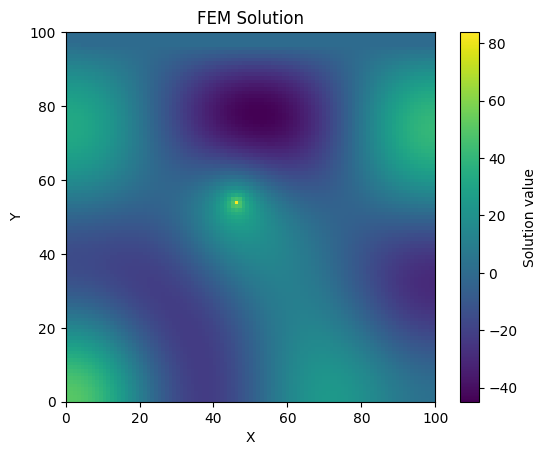

In [120]:

# and N, M are the number of elements in x and y directions

# Step 1: Create an empty matrix for nodes
solution_matrix = np.zeros((N+1, M+1))

# Step 2: Fill the matrix with values from solution_full
# The original node numbering goes row-wise (y increases with row, x increases with column)
for node in range((N+1)*(M+1)):
    row = node // (M+1)   # integer division gives y-index
    col = node % (M+1)    # modulo gives x-index
    solution_matrix[row, col] = solution_full[node]

# Step 3: Print or plot
print("Solution as matrix:")
print(solution_matrix)

# Optional: visualize with imshow
import matplotlib.pyplot as plt
plt.imshow(solution_matrix, origin='lower', cmap='viridis', extent=[0, M, 0, N])
plt.colorbar(label='Solution value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('FEM Solution')
plt.show()